In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
import numpy as np
import pandas as pd
import os
import random
import librosa as libr
import librosa.display as disp
from IPython.display import Audio
from scipy.io import wavfile

In [3]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchaudio.transforms import Resample
from torchsummary import summary
from torch.utils.data import SubsetRandomSampler,Subset,DataLoader
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio
from torchmetrics.audio import pesq as PESQ

In [4]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA RTX A5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
retrain = 0
save_per_epoch = 5
torch.manual_seed(0)

In [7]:
config = {
    'sample_rate':16000,
    'max_duration':4,
    'n_fft':1024,
    'hop_length':512,
    'n_mels':64,
    'batch_size':16,
    'learning_rate': 0.0001,
    'lr_decay':(0.9, 0.999),
    'patience':20,
    'epochs':200,
    'val_split':0.999,
}

In [ ]:
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_testset_wav.zip?sequence=1&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_trainset_28spk_wav.zip?sequence=2&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_trainset_28spk_wav.zip?sequence=6&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_testset_wav.zip?sequence=5&isAllowed=y

In [ ]:
# !unzip "./data/noisy_trainset_28spk_wav.zip"
# !unzip "./data/clean_trainset_28spk_wav.zip"
# !unzip "./data/noisy_testset_wav.zip"
# !unzip "./data/clean_testset_wav.zip"

In [8]:
train_noisy_data_path = "./noisy_trainset_28spk_wav/"
train_clean_data_path = "./clean_trainset_28spk_wav/"
test_noisy_data_path = "./noisy_testset_wav/"
test_clean_data_path = "./clean_testset_wav/"

In [9]:
class AudioDataset(Dataset):
    def __init__(self,noisy_path,clean_path, transform=None, sample_rate=None,max_duration=None):

        #get file paths
        noisy_all_items = os.listdir(noisy_path)
        noisy_files = [item for item in noisy_all_items if os.path.isfile(os.path.join(noisy_path, item)) and item.lower().endswith('.wav')]
        noisy_file_paths = [os.path.join(noisy_path, file_name) for file_name in noisy_files]
        clean_file_paths = [os.path.join(clean_path, file_name) for file_name in noisy_files]

        #initialize variables
        self.noisy_data = noisy_file_paths
        self.clean_data = clean_file_paths
        self.transform = transform
        self.sample_rate = sample_rate
        self.max_duration = max_duration
        self.num_samples = sample_rate*max_duration

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        noisy_waveform, sr = torchaudio.load(self.noisy_data[idx])
        if sr != config['sample_rate']:
            resampler = torchaudio.transforms.Resample(sr, config['sample_rate'])
            noisy_waveform = resampler(noisy_waveform)
        noisy_waveform = torch.tensor(noisy_waveform.numpy().reshape(-1))
        if noisy_waveform.shape[0] < self.num_samples:
            num_missing_samples = self.num_samples - noisy_waveform.shape[0]
            noisy_waveform = F.pad(noisy_waveform, (0, num_missing_samples))
        noisy_waveform = torch.tensor(noisy_waveform[:self.num_samples])
        noisy_audio = noisy_waveform
        if self.transform:
            noisy_waveform = self.transform(noisy_waveform)


        clean_waveform, sr = torchaudio.load(self.clean_data[idx])
        if sr != config['sample_rate']:
            resampler = torchaudio.transforms.Resample(sr, config['sample_rate'])
            clean_waveform = resampler(clean_waveform)
        clean_waveform = torch.tensor(clean_waveform.numpy().reshape(-1))
        if clean_waveform.shape[0] < self.num_samples:
            num_missing_samples = self.num_samples - clean_waveform.shape[0]
            clean_waveform = F.pad(torch.tensor(clean_waveform), (0, num_missing_samples))
        clean_waveform = torch.tensor(clean_waveform[:self.num_samples])
        clean_audio = clean_waveform
        if self.transform:
            clean_waveform = self.transform(clean_waveform)
        return noisy_waveform, clean_waveform, noisy_audio, clean_audio

In [10]:
def split_dataset(dataset, perc=0.9):
    dataset_indices = list(range(len(dataset)))
    random.shuffle(dataset_indices)
    train_indices = dataset_indices[:int(len(dataset_indices) * perc)]
    val_indices = dataset_indices[int(len(dataset_indices) * perc):]
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    return train_dataset,val_dataset

In [11]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config['sample_rate'],
                                                      n_fft=config['n_fft'],
                                                      hop_length=config['hop_length'],
                                                      n_mels=config['n_mels'])

train_dataset = AudioDataset(noisy_path=train_noisy_data_path,
                       clean_path=train_clean_data_path,
                       sample_rate=config['sample_rate'],
                       max_duration=config['max_duration'],
                       transform=mel_spectrogram)
test_dataset = AudioDataset(noisy_path=test_noisy_data_path,
                       clean_path=test_clean_data_path,
                       sample_rate=config['sample_rate'],
                       max_duration=config['max_duration'],
                       transform=mel_spectrogram)

train_dataset, val_dataset = split_dataset(train_dataset,config['val_split'])

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {config['batch_size']}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {config['batch_size']}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {config['batch_size']}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f98c2e41dd0>, <torch.utils.data.dataloader.DataLoader object at 0x7f98c2e16a10>)
Length of train dataloader: 723 batches of 16
Length of val dataloader: 1 batches of 16
Length of test dataloader: 52 batches of 16


In [12]:
class BaseUNetModel(nn.Module):
    def __init__(self):
        super(BaseUNetModel,self).__init__()
        
        self.down_conv_layer_1 = nn.Sequential(
            nn.Conv2d(1, 64 , kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )        
 
        self.down_conv_layer_2 = nn.Sequential(
            nn.Conv2d(64, 128 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            
        ) 
    
        self.down_conv_layer_3 = nn.Sequential(
            nn.Conv2d(128, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            
        ) 
        
        self.down_conv_layer_4 = nn.Sequential(
            nn.Conv2d(256, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),   
        )

        self.down_conv_layer_5 = nn.Sequential(
            nn.Conv2d(256, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),   
        ) 

        self.down_conv_layer_6 = nn.Sequential(
            nn.Conv2d(256, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),   
        ) 
        
        self.up_conv_layer_1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=(2,3), stride=2, padding=0),
            nn.InstanceNorm2d(256),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )
        
        self.up_conv_layer_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=(2,3), stride=2, padding=0),
            nn.InstanceNorm2d(256),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )
        
        self.up_conv_layer_3 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=(2,3), stride=2, padding=0),
            nn.InstanceNorm2d(128),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )

        self.up_conv_layer_4 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=(4,5), stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )

        self.up_conv_layer_5 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=(4), stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(), 
        )
                
        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv_layer_final = nn.Conv2d(128, 1, kernel_size=4, padding=1)

    def forward(self,x):
        # print("x", x.shape)
        enc1 = self.down_conv_layer_1(x)
        # print("enc1", enc1.shape)
        enc2 = self.down_conv_layer_2(enc1) 
        # print("enc2", enc2.shape)
        enc3 = self.down_conv_layer_3(enc2) 
        # print("enc3", enc3.shape)
        enc4 = self.down_conv_layer_4(enc3)
        # print("enc4", enc4.shape)
        enc5 = self.down_conv_layer_5(enc4)
        # print("enc5", enc5.shape)
        

        dec1 = self.up_conv_layer_1(enc5)
        # print("dec1", dec1.shape)
        dec14 = torch.cat((dec1, enc4), 1)
        # print("dec14", dec14.shape)

        dec2 = self.up_conv_layer_2(dec14)
        # print("dec2", dec2.shape)
        dec23 = torch.cat((dec2, enc3), 1)
        # print("dec23", dec23.shape)

        dec3 = self.up_conv_layer_3(dec23)
        # print("dec3", dec3.shape)
        dec32 = torch.cat((dec3, enc2), 1)
        # print("dec32", dec32.shape)

        dec4 = self.up_conv_layer_4(dec32)
        # print("dec4", dec4.shape)
        dec41 = torch.cat((dec4, enc1), 1)
        # print("dec41", dec41.shape)

        final = self.upsample_layer(dec41)
        # print("up", final.shape)
        final = self.zero_pad(final)
        # print("zero", final.shape)
        final = self.conv_layer_final(final)
        # print("final", final.shape)
        return final

In [57]:
model = BaseUNetModel()
model = model.cuda()

rand_inp = torch.randn(64,1,64,126).cuda()
rand_out = model(rand_inp)
print(rand_out.shape)

torch.Size([64, 1, 64, 126])


In [59]:
summary(model,input_size=(1, 64, 126), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 32, 63]           1,088
         LeakyReLU-2           [64, 64, 32, 63]               0
            Conv2d-3          [64, 128, 16, 31]         131,200
    InstanceNorm2d-4          [64, 128, 16, 31]               0
         LeakyReLU-5          [64, 128, 16, 31]               0
            Conv2d-6           [64, 256, 8, 15]         524,544
    InstanceNorm2d-7           [64, 256, 8, 15]               0
         LeakyReLU-8           [64, 256, 8, 15]               0
            Conv2d-9            [64, 256, 4, 7]       1,048,832
   InstanceNorm2d-10            [64, 256, 4, 7]               0
        LeakyReLU-11            [64, 256, 4, 7]               0
          Dropout-12            [64, 256, 4, 7]               0
           Conv2d-13            [64, 256, 2, 3]       1,048,832
   InstanceNorm2d-14            [64, 25

In [ ]:
# ssnr_fs = 22050
# ssnr = ScaleInvariantSignalNoiseRatio().cuda()

# def get_ssnr(preds, clean):
#     print(preds.shape, clean.shape)
#     inv_mel = preds.cpu().data.numpy()
#     S = libr.feature.inverse.mel_to_stft(inv_mel, sr=ssnr_fs)#config['sample_rate'])
#     preds_audio = libr.griffinlim(S)
#     ssnr_score = ssnr(preds_audio,clean).item()
#     return ssnr_score

In [ ]:
# get_pesq_fs = 16000
# pesq = PESQ.PerceptualEvaluationSpeechQuality(get_pesq_fs,'nb').cuda()

# def get_pesq(preds, clean):
#     inv_mel = preds.cpu().data.numpy()
#     S = libr.feature.inverse.mel_to_stft(inv_mel, sr=ssnr_fs)#config['sample_rate'])
#     preds_audio = libr.griffinlim(S)
#     resampler = Resample(orig_freq=config['sample_rate'], new_freq=get_pesq_fs).cuda()
#     preds_resample = resampler(preds_audio)
#     clean_resample = resampler(clean)
#     pesq_score = pesq(preds_resample,clean_resample).item()
#     return pesq_score

In [60]:
def sample_preprop(transform):
    sample_path = './noisy_testset_wav/p232_001.wav'
    num_samples = config['max_duration']*config['sample_rate']

    noisy_sample, sr = torchaudio.load(sample_path)
    noisy_waveform = torch.tensor(noisy_sample.numpy().reshape(-1))
    if noisy_waveform.shape[0] < num_samples:
        num_missing_samples = num_samples - noisy_waveform.shape[0]
        noisy_waveform = F.pad(noisy_waveform, (0, num_missing_samples))
    noisy_waveform = torch.tensor(noisy_waveform[:num_samples])
    if transform:
        noisy_waveform = transform(noisy_waveform)
    noisy_waveform = noisy_waveform.unsqueeze(dim=0).unsqueeze(dim=0)
    return noisy_waveform
sample_noisy_waveform = sample_preprop(mel_spectrogram)
print(sample_noisy_waveform.shape)

torch.Size([1, 1, 64, 126])


In [17]:
def save_inter_ouput(model,transform):
    noisy_waveform = sample_noisy_waveform.cuda()
    model = model.cuda()
    
    model.eval()
    pred = model(noisy_waveform).squeeze(1).squeeze(0)
    mel = pred.cpu().data.numpy()
    S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
    pred_audio = libr.griffinlim(S)
    return pred_audio

In [18]:
train_len = len(train_dataloader)
val_len = len(val_dataloader)
test_len = len(test_dataloader)
print(train_len,val_len, test_len)

723 1 52


In [61]:
model = BaseUNetModel()
model = model.cuda()

if retrain:
  PATH = './denoise_model_16kHz'
  model.load_state_dict(torch.load(PATH))
  print("loaded pretrained model..")
  
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], betas=config['lr_decay'])
# early_stopping = optim.EarlyStopping(patience=config['patience'], verbose=True)

train_losses,val_losses = [],[]
train_scores_ssnr,val_scores_ssnr = [],[]
train_scores_pesq,val_scores_pesq = [],[]
num_epochs = config['epochs']
intermediate_ouputs = {}

print("starting training..")
for epoch in range(1,num_epochs+1):

  model.train()
  epoch_loss,epoch_ssnr,epoch_pesq = 0.0,0.0,0.0

  for i, data in enumerate(train_dataloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      X, y, noise , clean = data
      X = X.unsqueeze(1)
      X, y  = Variable(X.cuda()), Variable(y.cuda())
      # noise, clean = Variable(noise.cuda()),Variable(clean.cuda())

      optimizer.zero_grad()
      preds = model(X).squeeze(1)
      preds = preds.cuda()
      
      loss = criterion(preds.float(), y.float())
      # ssnr_score = get_ssnr(preds, clean)
      # pesq_score = get_pesq(preds, clean)

      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      
      # epoch_ssnr += ssnr_score
      # epoch_pesq += pesq_score

  train_losses.append(epoch_loss)
  # train_scores_ssnr.append(epoch_ssnr)
  # train_scores_pesq.append(epoch_pesq)
  #print(f'Training: Epoch {epoch}/{num_epochs} Loss: {epoch_loss:.4f} SSNR: {epoch_ssnr:.4f} PESQ: {epoch_pesq:.4f}')
  print(f'Training: Epoch {epoch}/{num_epochs} MSE Loss: {epoch_loss:.4f} MSE Lossperbatch: {epoch_loss/train_len:.4f}')
  if((epoch == 1) or (epoch%50 == 0)):
    intermediate_ouputs[str(epoch)] = save_inter_ouput(model,mel_spectrogram)
      
  #Validation
  model.eval()
  val_loss,val_ssnr,val_pesq = 0.0,0.0,0.0
  with torch.no_grad():
    for i, data in enumerate(val_dataloader, 0):
      X_val, y_val, noise_val,clean_val = data
      X_val = X_val.unsqueeze(1)
      X_val, y_val = Variable(X_val.cuda()), Variable(y_val.cuda())
      # noise_val, clean_val = Variable(noise_val.cuda()),Variable(clean_val.cuda())

      preds_val = model(X_val).squeeze(1).cuda()
      val_loss += criterion(preds_val.float(), y_val.float()).item()
      # val_ssnr += get_ssnr(preds_val, clean)
      # val_pesq += get_pesq(preds_val, clean)

  val_losses.append(val_loss)
  # val_scores_ssnr.append(val_ssnr)
  # val_scores_pesq.append(val_pesq)
  # print(f'Validation: Epoch {epoch}/{num_epochs} Loss: {val_loss:.4f} SSNR: {val_ssnr:.4f} PESQ: {epoch_pesq:.4f}')
  print(f'Validation: MSE Loss: {val_loss:.4f} MSE Lossperbatch: {val_loss/val_len:.4f}')
  if (epoch%save_per_epoch == 0):
    PATH = './denoise_model_16khz_200'
    torch.save(model.state_dict(), PATH)
  print("=======================================")

starting training..
Training: Epoch 1/200 MSE Loss: 1299431.4770 MSE Lossperbatch: 1797.2773
Validation: MSE Loss: 383.5429 MSE Lossperbatch: 383.5429
Training: Epoch 2/200 MSE Loss: 742008.5456 MSE Lossperbatch: 1026.2912
Validation: MSE Loss: 295.4881 MSE Lossperbatch: 295.4881
Training: Epoch 3/200 MSE Loss: 663429.0042 MSE Lossperbatch: 917.6058
Validation: MSE Loss: 265.4874 MSE Lossperbatch: 265.4874
Training: Epoch 4/200 MSE Loss: 621176.7131 MSE Lossperbatch: 859.1656
Validation: MSE Loss: 249.4536 MSE Lossperbatch: 249.4536
Training: Epoch 5/200 MSE Loss: 591982.8921 MSE Lossperbatch: 818.7868
Validation: MSE Loss: 234.0078 MSE Lossperbatch: 234.0078
Training: Epoch 6/200 MSE Loss: 569608.2503 MSE Lossperbatch: 787.8399
Validation: MSE Loss: 226.0852 MSE Lossperbatch: 226.0852
Training: Epoch 7/200 MSE Loss: 550549.7064 MSE Lossperbatch: 761.4795
Validation: MSE Loss: 216.0527 MSE Lossperbatch: 216.0527
Training: Epoch 8/200 MSE Loss: 534874.6552 MSE Lossperbatch: 739.7990
Val

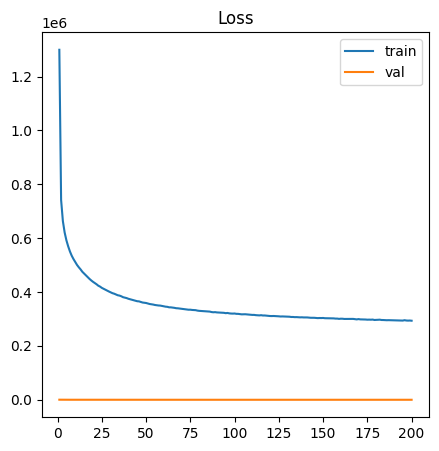

In [62]:
plt.figure(figsize=(5, 5))

# plt.subplot(1, 3, 1)
x = [i for i in range(1,len(train_losses)+1)]
plt.plot(x,train_losses, label='train')
plt.plot(x,val_losses, label='val')
plt.title('Loss')
plt.savefig('mel_loss_400.png')
plt.legend()

In [ ]:
plt.figure(figsize=(5, 5))

# plt.subplot(1, 3, 1)
x = [i for i in range(1,len(train_losses)+1)]
plt.plot(x,train_losses, label='train')
plt.plot(x,val_losses, label='val')
plt.title('Loss')
plt.legend()

# plt.subplot(1, 3, 2)
# plt.plot(torch.tensor(train_scores_ssnr), label='train')
# plt.plot(torch.tensor(val_scores_ssnr), label='val')
# plt.title('SSNR Scores')
# plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(train_scores_pesq, label='train')
# plt.plot(val_scores_pesq, label='test')
# plt.title('PESQ Scores')
# plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_loss,test_ssnr,test_pesq = 0.0,0.0,0.0
with torch.no_grad():
  for i, data in enumerate(test_dataloader, 0):
    X, y, noise, clean = data
    X = X.unsqueeze(1)
    X, y = Variable(X.cuda()), Variable(y.cuda())

    preds = model(X).squeeze(1)
    preds = preds.cuda()

    loss = criterion(preds.float().squeeze(1), y.float())
    # ssnr_score = get_ssnr(preds, clean)
    # pesq_score = get_pesq(preds, clean)

    test_loss += loss.item()
    # test_ssnr += ssnr_score
    # test_pesq += pesq_score

print(f'Test: Loss: {test_loss:.4f} Test: Lossperbatch: {test_loss/test_len:.4f} ')#SSNR: {test_ssnr:.4f} PESQ: {test_pesq:.4f}')

In [64]:
for k in intermediate_ouputs.keys():
    print(k, intermediate_ouputs[k].shape)

1 (64000,)
50 (64000,)
100 (64000,)
150 (64000,)
200 (64000,)


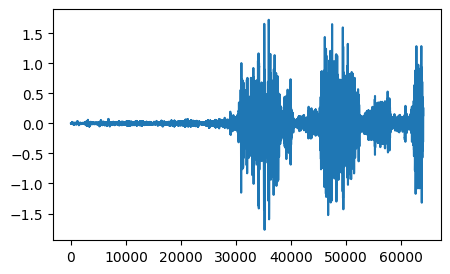

In [67]:
k = '1'
plt.figure(figsize=(5,3))
plt.plot(intermediate_ouputs[k])

filtered_sample_path = 'pred_400.wav'
wavfile.write(filtered_sample_path, 48000, intermediate_ouputs[k])
Audio(intermediate_ouputs[k],rate=48000)


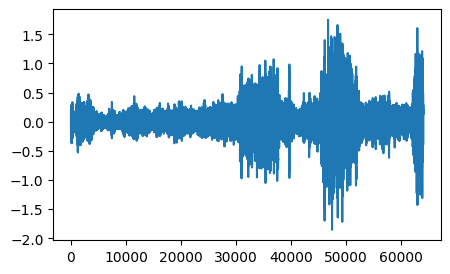

In [66]:
k = '50'
plt.figure(figsize=(5,3))
plt.plot(intermediate_ouputs[k])

filtered_sample_path = './pred_450.wav'
wavfile.write(filtered_sample_path, 48000, intermediate_ouputs[k])
Audio(intermediate_ouputs[k],rate=48000)



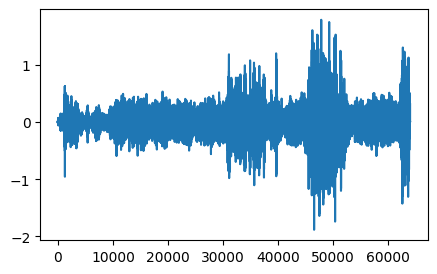

In [69]:
k = '100'
plt.figure(figsize=(5,3))
plt.plot(intermediate_ouputs[k])

filtered_sample_path = 'pred_500.wav'
wavfile.write(filtered_sample_path, 48000, intermediate_ouputs[k])
Audio(intermediate_ouputs[k],rate=48000)



In [13]:
model = BaseUNetModel()
model = model.cuda()

PATH = './denoise_model_16khz_200'
model.load_state_dict(torch.load(PATH))
print("loaded pretrained model..")
  

loaded pretrained model..


In [32]:
test_audio,test_outputs, noisy_audio, clean_audio = next(iter(test_dataloader))
outputs = model(test_audio.unsqueeze(dim=1).cuda()).squeeze(1)
mel = outputs[0].cpu().data.numpy()

In [33]:
mel.shape

(64, 126)

In [ ]:
n_stft = config['n_fft'] // 2 + 1 
inverse_mel = torchaudio.transforms.InverseMelScale(sample_rate=config['sample_rate'],
                                                      n_mels=config['n_mels'],
                                                      n_stft=n_stft)
inverse_wave = inverse_mel(mel)
inverse_wave

In [81]:
n = 2048
waveform, sample_rate = torchaudio.load("./clean_testset_wav/p232_001.wav")
mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n)
mel_spectrogram = mel_spectrogram_transform(waveform)
inverse_melscale_transform = torchaudio.transforms.InverseMelScale(n_stft=int(n // 2 + 1))
spectrogram = inverse_melscale_transform(mel_spectrogram)
inv_transform = torchaudio.transforms.GriffinLim(n_fft=n)
pred_waveform = inv_transform(spectrogram)

pred_waveform = pred_waveform.squeeze()
Audio(pred_waveform,rate=sample_rate)


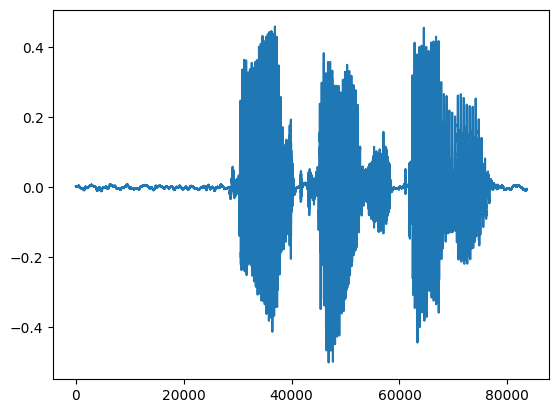

In [76]:
s = waveform.squeeze()
plt.plot(s)
Audio(s,rate=sample_rate)

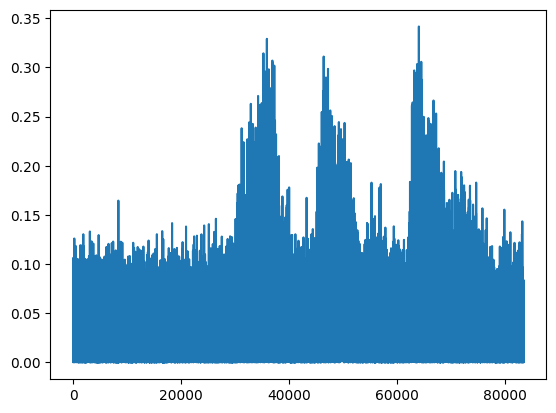

In [77]:
ps = pred_waveform.squeeze().abs()
plt.plot(ps)
Audio(ps,rate=sample_rate)

tensor([[0.0015, 0.0003, 0.0015,  ..., 0.0023, 0.0055, 0.0023]])

In [26]:
waveform, sample_rate = torchaudio.load("./clean_testset_wav/p232_001.wav")

n_fft = 512

n_stft = int((n_fft//2) + 1)
transofrm = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft)
invers_transform = torchaudio.transforms.InverseMelScale(sample_rate=sample_rate, n_stft=n_stft)
grifflim_transform = torchaudio.transforms.GriffinLim(n_fft=n_fft)

mel_specgram = transofrm(waveform)
inverse_waveform = invers_transform(mel_specgram)
pseudo_waveform = grifflim_transform(inverse_waveform)

Audio(pseudo_waveform, rate=sample_rate)

In [20]:
Audio(waveform, rate=48000)

In [76]:
128*600

76800

In [40]:
waveform, sample_rate = torchaudio.load("./clean_testset_wav/p232_001.wav")

spectrogram_transform = torchaudio.transforms.Spectrogram(sample_rate,power=None)
spectrogram = spectrogram_transform(waveform).type(torch.complex64)

inverse_transform = torchaudio.transforms.InverseSpectrogram(sample_rate)
pred_waveform = inverse_transform(spectrogram)

In [41]:
waveform.shape,pred_waveform.shape

(torch.Size([1, 83582]), torch.Size([1, 72000]))

In [42]:
Audio(waveform, rate=48000)

In [43]:
Audio(pred_waveform, rate=48000)

In [44]:
spectrogram.shape

torch.Size([1, 24001, 4])

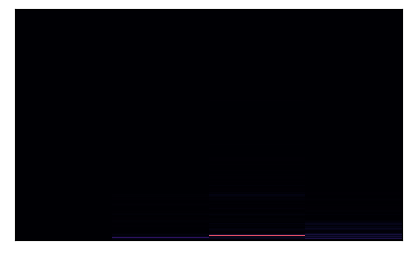

In [61]:
plt.figure(figsize=(5,3))
libr.display.specshow(spectrogram.numpy()[0],sr=config['sample_rate'])
plt.show()

In [ ]:
sgram_mag, _ = libr.magphase(spectrogram.real.numpy()[0])
mel_scale_sgram = libr.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
libr.display.specshow(mel_scale_sgram)

In [67]:
pred_waveform = inverse_transform(mel_scale_sgram.real)
Audio(pred_waveform, rate=48000)

AttributeError: 'numpy.ndarray' object has no attribute 'is_complex'

In [70]:
def get_sample_predicted_ouputs(id=0):
  test_audio,test_outputs, noisy_audio, clean_audio = next(iter(test_dataloader))
  outputs = model(test_audio.unsqueeze(dim=1).cuda()).squeeze(1)
  mel = outputs[id].cpu().data.numpy()
  S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
  pred_audio = libr.griffinlim(S)
  print(noisy_audio[id].shape,clean_audio[id].shape, pred_audio.shape)
  print(test_audio[id].shape,test_outputs[id].shape, outputs[id].shape)
  return [noisy_audio[id],clean_audio[id], pred_audio],[test_audio[id],test_outputs[id],outputs[id]]

In [71]:
audio_outputs,mel_outputs = get_sample_predicted_ouputs(id=5)

torch.Size([64000]) torch.Size([64000]) (64000,)
torch.Size([64, 126]) torch.Size([64, 126]) torch.Size([64, 126])


In [73]:
Audio(audio_outputs[0], rate=16000)

In [75]:
Audio(audio_outputs[1], rate=16000)

In [77]:
Audio(audio_outputs[2], rate=16000)

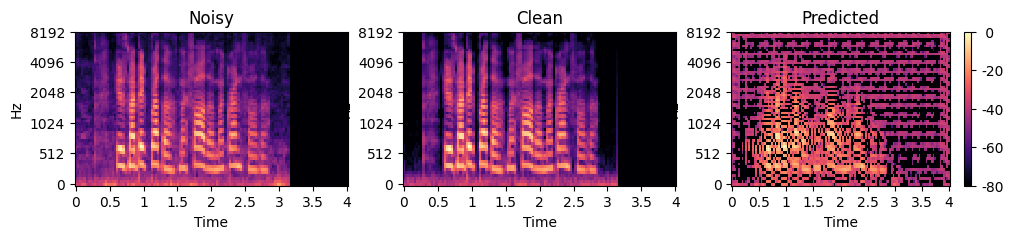

In [78]:
S1,S2,S3 = mel_outputs
S3 = S3.cpu().detach().numpy()
plt.figure(figsize=(12, 2))

plt.subplot(1, 3, 1)
S_dB = libr.power_to_db(S1, ref=np.max)
img = libr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=config['sample_rate'],
                         fmax=8000)
plt.title('Noisy')

plt.subplot(1, 3, 2)
S_dB = libr.power_to_db(S2, ref=np.max)
img = libr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=config['sample_rate'],
                         fmax=8000)
plt.title('Clean')

plt.subplot(1, 3, 3)
S_dB = libr.power_to_db(S3, ref=np.max)
img = libr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=config['sample_rate'],
                         fmax=8000)
plt.title('Predicted')
plt.colorbar(format='%2.0f')
plt.savefig('mel_pred_600.png')
plt.show()


In [ ]:
# S = mel_outputs[2].cpu().detach().numpy()

# fig, ax = plt.subplots()
# S_dB = libr.power_to_db(S, ref=np.max)
# img = libr.display.specshow(S_dB, x_axis='time',
#                          y_axis='mel', sr=config['sample_rate'],
#                          fmax=8000, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')
# # plt.savefig('pred.png')

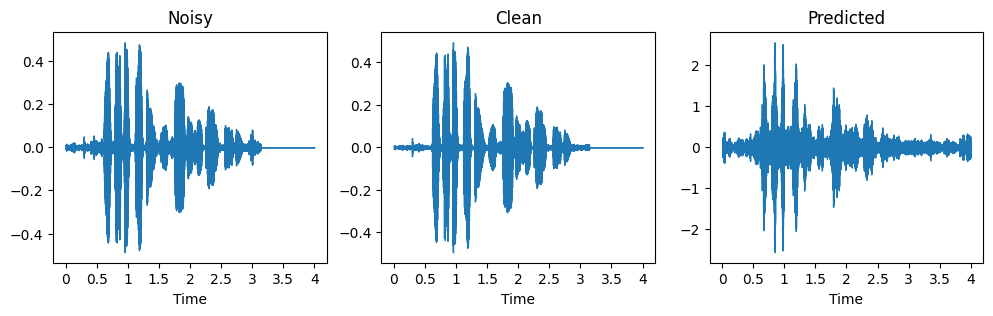

In [79]:
S1,S2,S3 = audio_outputs[0].numpy(),audio_outputs[1].numpy(),audio_outputs[2]
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
disp.waveshow(S1,sr=config['sample_rate'])
plt.title('Noisy')

plt.subplot(1, 3, 2)
disp.waveshow(S2,sr=config['sample_rate'])
plt.title('Clean')

plt.subplot(1, 3, 3)
disp.waveshow(S3,sr=config['sample_rate'])
plt.title('Predicted')
plt.savefig('sig_pred_600.png')
plt.show()

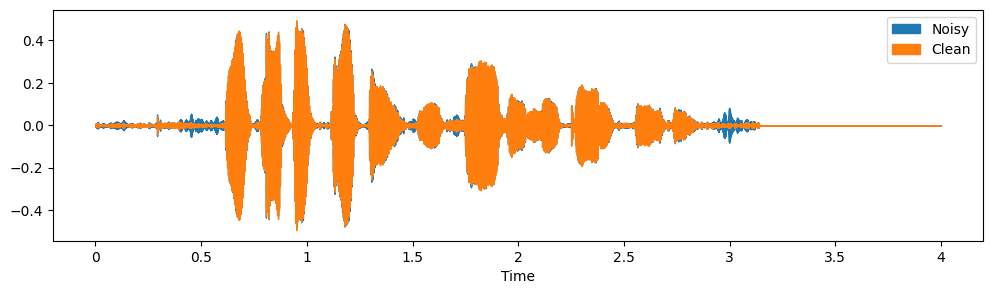

In [80]:
plt.figure(figsize=(12, 3))
disp.waveshow(S1,sr=config['sample_rate'],label='Noisy')
disp.waveshow(S2,sr=config['sample_rate'],label='Clean')
plt.legend()
plt.show()

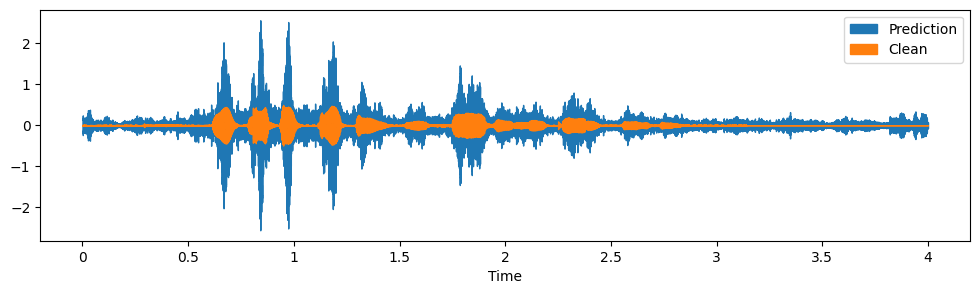

In [81]:
plt.figure(figsize=(12, 3))
disp.waveshow(S3,sr=config['sample_rate'],label='Prediction')
disp.waveshow(S2,sr=config['sample_rate'],label='Clean')
plt.legend()
plt.show()

In [ ]:
# use torch metrics
# use a baseline model network
# use torch summary tensor board, callback

In [82]:
def get_sample_predicted_ouputs(id=0):
  test_audio,test_outputs, noisy_audio, clean_audio = next(iter(test_dataloader))
  outputs = model(test_audio.unsqueeze(dim=1).cuda()).squeeze(1)
  mel = outputs[id].cpu().data.numpy()
  S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
  pred_audio = libr.griffinlim(S)
  print(noisy_audio[id].shape,clean_audio[id].shape, pred_audio.shape)
  print(test_audio[id].shape,test_outputs[id].shape, outputs[id].shape)
  return [noisy_audio[id],clean_audio[id], pred_audio],[test_audio[id],test_outputs[id],outputs[id]]

In [ ]:
PATH = './denoise_model_'+str(num_epochs)
torch.save(model.state_dict(), PATH)

In [ ]:
PATH = './denoise_model_200'
model = BaseUNetModel()
model = model.cuda()
model.load_state_dict(torch.load(PATH))

In [ ]:
def calculate_test_PESQ(data_loader):
    scores,pred_scores = [],[]
    pesq = PESQ.PerceptualEvaluationSpeechQuality(fs=16000,mode='wb')
    for i,data in enumerate(data_loader, 0):
        X,y,noise,clean = data
        score = pesq(noise.unsqueeze(0),clean.unsqueeze(0)).item()
        scores.append(score)

        outputs = model(X.unsqueeze(dim=1).cuda()).squeeze(1)
        mel = outputs.cpu().data.numpy()
        S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
        pred_audio = libr.griffinlim(S)
        print(pred_audio)
        pred_score = pesq(pred_audio.unsqueeze(0),clean.unsqueeze(0)).item()
        pred_scores.append(pred_score)

    return np.mean(scores,),np.mean(pred_scores)

In [88]:
mean_score, pred_mean_score = calculate_test_PESQ(test_dataloader)
mean_score,pred_mean_score

: 

In [ ]:
def calculate_test_SSNR(data_loader):
    scores,pred_scores = [],[]
    ssnr = ScaleInvariantSignalNoiseRatio()
    for i,data in enumerate(data_loader, 0):
        X,y,noise,clean = data
        score = ssnr(noise.unsqueeze(0),clean.unsqueeze(0)).item()
        scores.append(score)

        # outputs = model(X.unsqueeze(dim=1).cuda()).squeeze(1)
        # mel = outputs[id].cpu().data.numpy()
        # S = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
        # pred_audio = libr.griffinlim(S)

        # pred_score = ssnr(pred_audio.unsqueeze(0),clean.unsqueeze(0)).item()
        # pred_scores.append(pred_score)

    return np.mean(scores,),np.mean(pred_scores)

In [ ]:
mean_score, pred_mean_score = calculate_test_SSNR(test_dataloader)
mean_score,pred_mean_score